In [1]:
import os
import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf

if os.getcwd().split('/')[-1] == 'notebook':
    os.chdir('..')

from cma import CMA

In [2]:
tf.random.set_seed(444)

def fitness_fn(x):
    """
    Six-Hump Camel Function
    https://www.sfu.ca/~ssurjano/camel6.html
    """
    return (
        (4 - 2.1 * x[:,0]**2 + x[:,0]**4 / 3) * x[:,0]**2 +
        x[:,0] * x[:,1] +
        (-4 + 4 * x[:,1]**2) * x[:,1]**2
    )

In [3]:
def plot_six_hump_camel_fn(mean=None, solutions=None, show_axes=False):
    a = np.linspace(-2, 2, 100)
    b = np.linspace(-1, 1, 100)
    y = lambda x1, x2: fitness_fn(np.array([[x1, x2]]))[0]

    A, B = np.meshgrid(a, b)
    zs = np.array([y(u, v) for u, v in zip(np.ravel(A), np.ravel(B))])
    Z = zs.reshape(A.shape)

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    if mean is not None:
        ax.scatter3D(
            [mean[0]], 
            [mean[1]], 
            [y(mean[0], mean[1])], 
            depthshade=False, 
            marker='+', 
            color='red',
            s=50,
        )

    if solutions is None:
        solutions = []
        
    for i, solution in enumerate(solutions):
        ax.scatter3D(
            [solution[0]], 
            [solution[1]], 
            [y(solution[0], solution[1])], 
            depthshade=False, 
            marker='o', 
            color='red' if (i+1) <= len(solutions) / 2 else 'grey',
            s=30,
        )

    ax.plot_surface(A, B, Z, cmap='cool', alpha=0.8)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1.1, 6])
    ax.view_init(50, -80)
    ax.grid(False)
    
    if not show_axes:
        plt.axis('off')

In [4]:
cma = CMA(
    initial_solution=[1.7, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
)

In [5]:
cma.search(10)

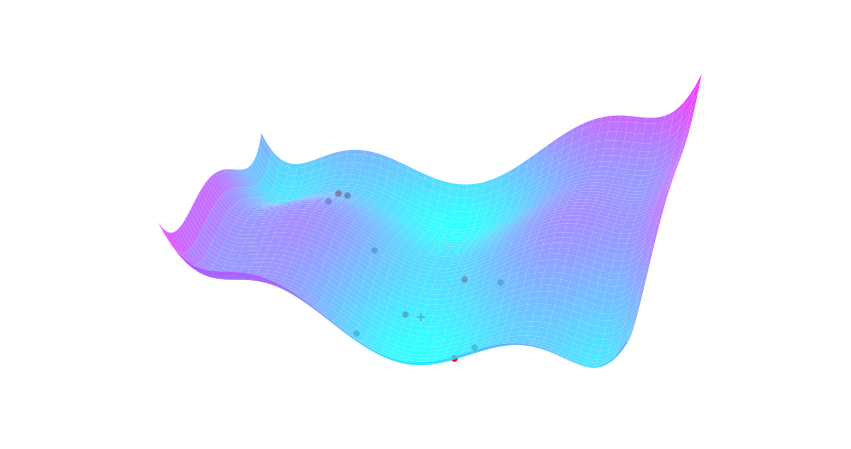

In [6]:
plot_six_hump_camel_fn(
    mean=cma.best_solution(),
    solutions=cma.current_population.numpy(),
)